In [1]:
!pip install biopython
!pip install obonet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 28.8 MB/s eta 0:00:0000:0100:01


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import Bio # Biopython library
from Bio import SeqIO # SeqIO from Biopython for parsing sequence files
import obonet # obonet for parsing OBO files
import gc # garbage collection
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # metrics for model evaluation
from sklearn.preprocessing import LabelEncoder # LabelEncoder for encoding categorical labels
from sklearn.model_selection import train_test_split # for splitting data into training and testing sets
import random

In [3]:
obo_path = '/kaggle/input/cafa-6-protein-function-prediction/Train/go-basic.obo' # Gene Ontology Basic OBO file
fasta_path = '/kaggle/input/cafa-6-protein-function-prediction/Train/train_sequences.fasta'
term_path = '/kaggle/input/cafa-6-protein-function-prediction/Train/train_terms.tsv'
taxonomy_path = '/kaggle/input/cafa-6-protein-function-prediction/Train/train_taxonomy.tsv'

In [4]:
term_df = pd.read_csv(term_path, sep='\t')

In [5]:
taxonomy_df = pd.read_csv(taxonomy_path, sep='\t', names=['EntryID', 'taxonomyID'])

In [6]:
taxonomy_df.head() # Display the first few rows of the taxonomy DataFrame

,EntryID,taxonomyID
0,A0A0C5B5G6,9606
1,A0JNW5,9606
2,A0JP26,9606
3,A0PK11,9606
4,A1A4S6,9606


In [7]:
fasta_data = list(SeqIO.parse(fasta_path, "fasta")) # Parse the FASTA file and store sequences as a list of SeqRecord objects

In [8]:
def get_processed_fasta_df(fasta_data):
    """Processes FASTA data into a DataFrame with EntryID and fasta_sequence."""
    fasta_dict_list = []
    for fasta_seq in fasta_data:
        # Extract EntryID from the FASTA header and store sequence
        entry = fasta_seq.id.split('|')[1]
        fasta_dict_list.append({
            "EntryID": entry,
            "fasta_sequence": str(fasta_seq.seq)
        })
    return pd.DataFrame(fasta_dict_list)

# Process the FASTA data into a DataFrame
fasta_df = get_processed_fasta_df(fasta_data)

# Merge term_df with fasta_df based on 'EntryID'
merged_df = pd.merge(term_df, fasta_df, on="EntryID", how='left')

# Merge the result with taxonomy_df based on 'EntryID'
merged_df = pd.merge(merged_df, taxonomy_df, on="EntryID", how="left")

# Display the first few rows of the merged DataFrame
merged_df.head()

,EntryID,term,aspect,fasta_sequence,taxonomyID
0,Q5W0B1,GO:0000785,C,MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...,9606
1,Q5W0B1,GO:0004842,F,MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...,9606
2,Q5W0B1,GO:0051865,P,MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...,9606
3,Q5W0B1,GO:0006275,P,MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...,9606
4,Q5W0B1,GO:0006513,P,MAQTVQNVTLSLTLPITCHICLGKVRQPVICINNHVFCSICIDLWL...,9606


# EDA

## Counting subontologies

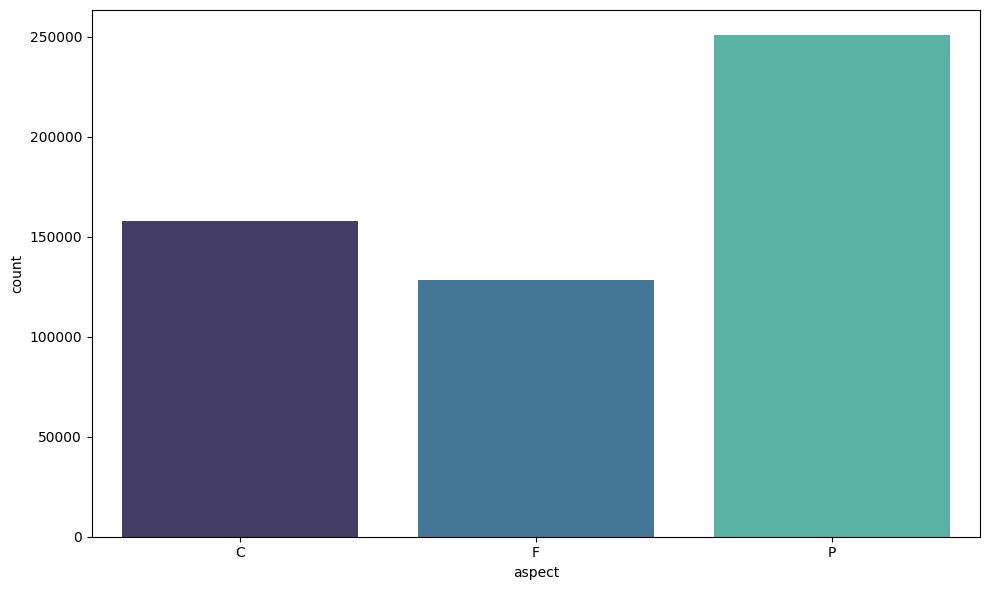

In [9]:
import seaborn as sns # for data visualization

plt.figure(figsize=(10, 6))

# Create a countplot of the 'aspect' column in term_df, representing subontologies (C, F, P)
sns.countplot(data=term_df, x='aspect', palette='mako')
plt.tight_layout()
plt.show()

## Counting terms for Cellular Component

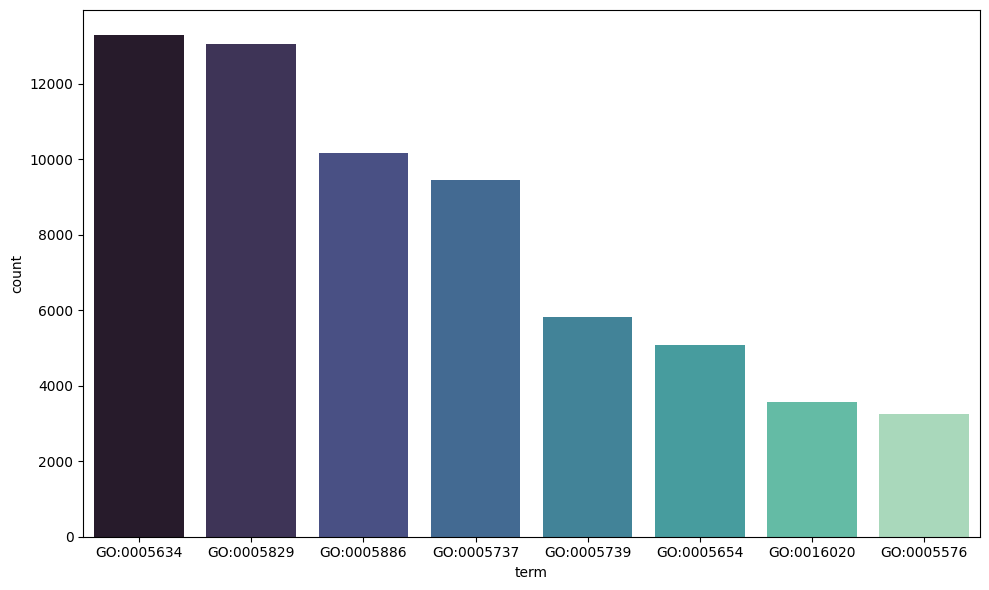

In [10]:
# number of most common terms to display
k = 8

# Get the k most common 'term' entries for 'Cellular Component' (aspect 'C')
k_most_common_c_term_counts = term_df[term_df['aspect'] == 'C']['term'].value_counts().head(k)

# Extract the term names from the counts for filtering and ordering
k_most_common_c_term = [term for term in k_most_common_c_term_counts.index]

plt.figure(figsize=(10, 6))

# Create a countplot for the top k cellular component terms
# Filter the DataFrame to include only these terms
sns.countplot(data=term_df[term_df['term'].isin(k_most_common_c_term)], x='term', palette='mako', order=k_most_common_c_term_counts.index)
plt.tight_layout()
plt.show()

## Counting terms for Molecular Function

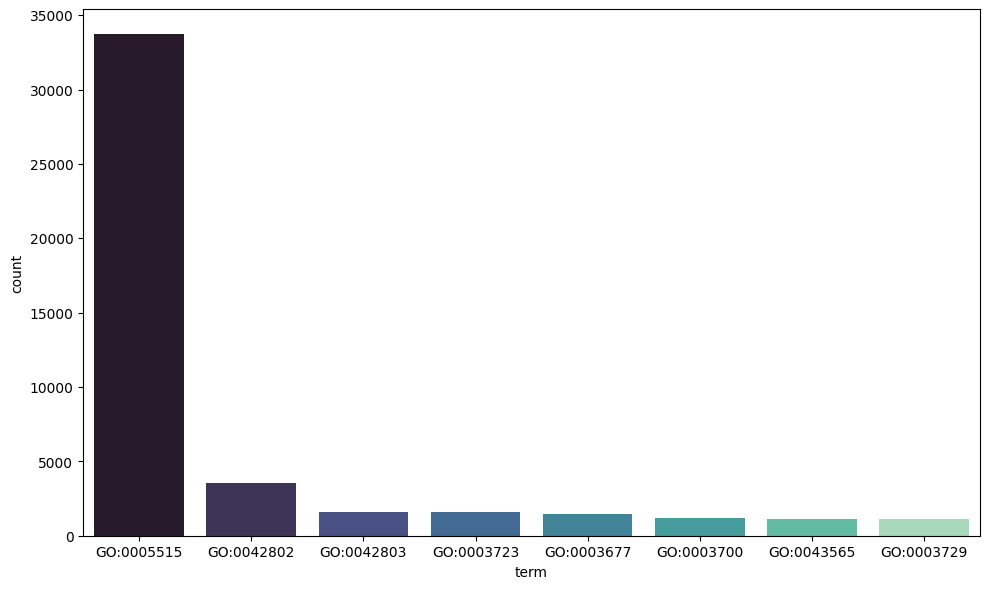

In [11]:
# Get the k most common 'term' entries for 'Molecular Function' (aspect 'F')
k_most_common_f_term_counts = term_df[term_df['aspect'] == 'F']['term'].value_counts().head(k)

# Extract the term names from the counts for filtering and ordering
k_most_common_f_term = [term for term in k_most_common_f_term_counts.index]

plt.figure(figsize=(10, 6))

# Create a countplot for the top k molecular function terms
# Filter the DataFrame to include only these terms
sns.countplot(data=term_df[term_df['term'].isin(k_most_common_f_term)], x='term', palette='mako', order=k_most_common_f_term_counts.index)
plt.tight_layout()
plt.show()

## Counting terms for Biological Process

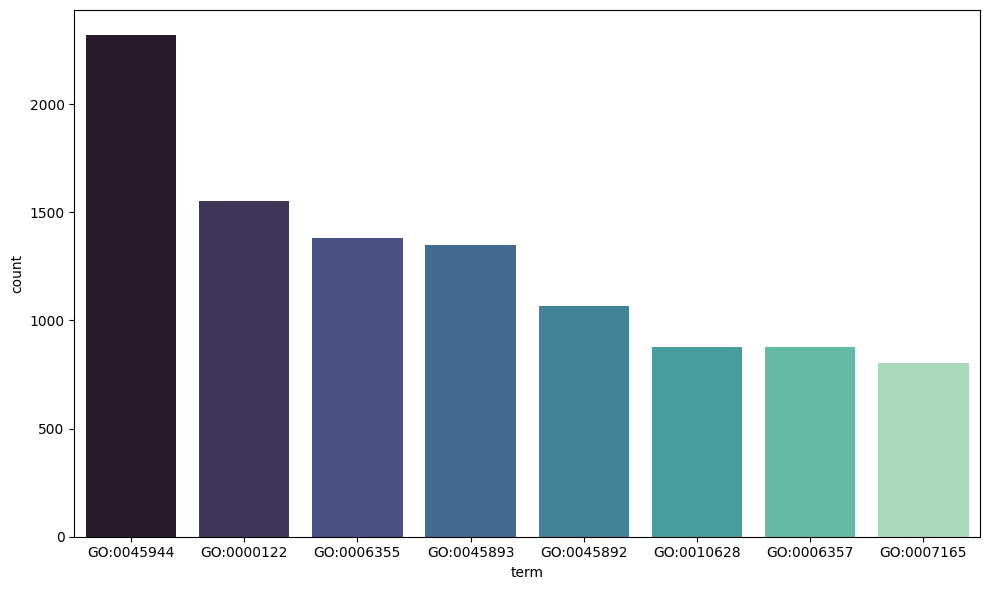

In [12]:
# Get the k most common 'term' entries for 'Biological Process' (aspect 'P')
k_most_common_p_term_counts = term_df[term_df['aspect'] == 'P']['term'].value_counts().nlargest(k)

# Extract the term names from the counts for filtering and ordering
k_most_common_p_term = k_most_common_p_term_counts.index.tolist()

plt.figure(figsize=(10, 6))

# Create a countplot for the top k biological process terms
# Filter the DataFrame to include only these terms
sns.countplot(data=term_df[term_df['term'].isin(k_most_common_p_term)], x='term', palette='mako', order=k_most_common_p_term_counts.index)
plt.tight_layout()
plt.show()

## Fasta sequence length histogram with kde,

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


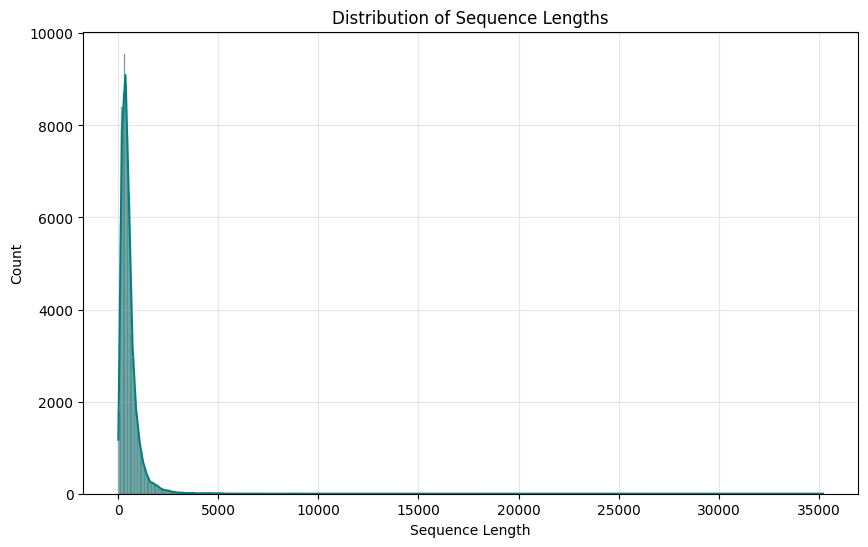

In [13]:
# number of sequences in fasta_data
# len(fasta_data)

# Extract fasta sequences as strings into a list
fasta_sequences_list = [str(x.seq) for x in fasta_data]

lengths = [len(seq) for seq in fasta_sequences_list]

plt.figure(figsize=(10, 6))

# Create a histogram of sequence lengths with a Kernel Density Estimate (KDE)
# 'kde=True' overlays a density curve
sns.histplot(lengths, bins=500, kde=True, color='teal')

plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

## Taxonomies countplot

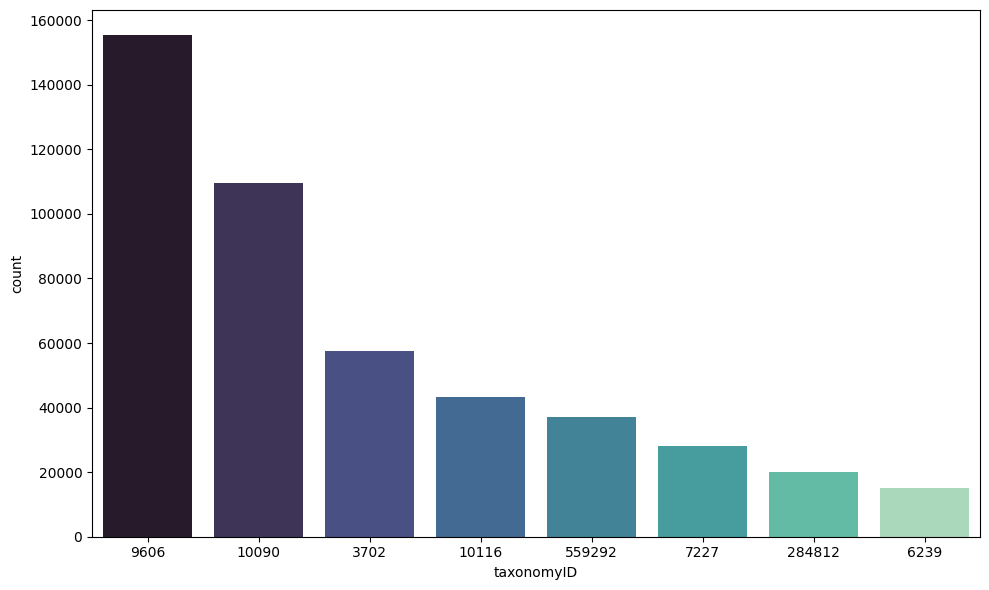

In [14]:
# Define the number of most common taxonomy IDs to display
k = 8

# Get the k most common 'taxonomyID' entries from the merged_df
k_most_common_taxonomy_tid_counts = merged_df['taxonomyID'].value_counts().nlargest(k)

# Extract the taxonomy IDs from the counts for filtering and ordering
k_most_common_taxonomy_id = k_most_common_taxonomy_tid_counts.index.tolist()

# Create a subset of the DataFrame containing only the top k taxonomy IDs
subset_df = merged_df[merged_df['taxonomyID'].isin(k_most_common_taxonomy_id)]

plt.figure(figsize=(10, 6))

# Create a countplot for the top k taxonomy IDs
sns.countplot(
    data=subset_df,
    x='taxonomyID',
    order=k_most_common_taxonomy_tid_counts.index,
    palette='mako'
)
plt.tight_layout()
plt.show()

## Amino acid counts

In [15]:
from collections import Counter

# Concatenate all fasta sequences into a single string
all_sequences = "".join(merged_df['fasta_sequence'])

# Count the occurrences of each amino acid in the combined sequence string
aa_counts = Counter(all_sequences)

# Convert the amino acid counts to a pandas DataFrame and sort by count in descending order
aa_df = pd.DataFrame.from_dict(aa_counts, orient='index', columns=['count']).sort_values('count', ascending=False)

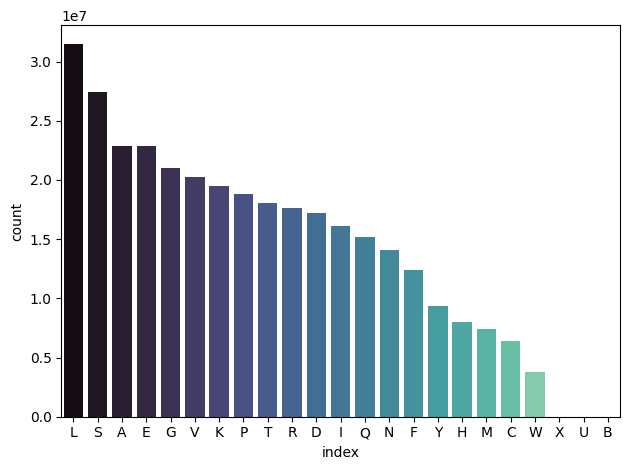

In [16]:
# Create a bar plot of amino acid counts
# 'data' is the DataFrame of amino acid counts, reset index to make amino acids a column
sns.barplot(
    data=aa_df.reset_index(),
    x='index',
    y='count',
    palette='mako'
)
plt.tight_layout()
plt.show()

## Number of GO Terms vs Sequence Length

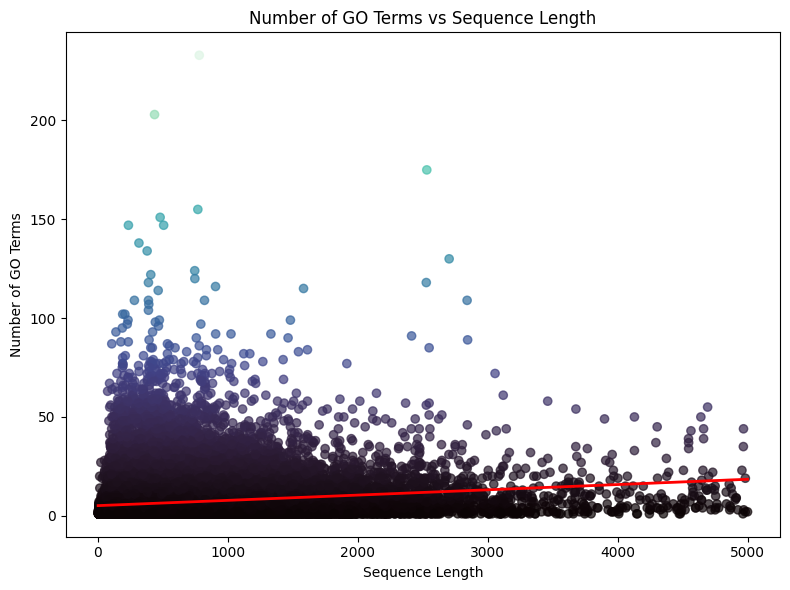

In [17]:
# Calculate the number of unique GO terms for each EntryID
term_counts = merged_df.groupby('EntryID')['term'].nunique().reset_index(name='num_terms')

# Extract unique EntryIDs and their corresponding fasta sequences
seq_lengths = merged_df[['EntryID', 'fasta_sequence']].drop_duplicates()

seq_lengths['seq_length'] = seq_lengths['fasta_sequence'].str.len()

# Merge term counts with sequence lengths based on 'EntryID'
entry_stats = pd.merge(term_counts, seq_lengths[['EntryID', 'seq_length']], on='EntryID')

# Filter out sequences longer than 5000
filtered_stats = entry_stats[entry_stats['seq_length'] <= 5000]

plt.figure(figsize=(8,6))

# Create a scatter plot of sequence length versus number of terms
# 'c' colors the points based on 'num_terms'
sc = plt.scatter(
    filtered_stats['seq_length'],
    filtered_stats['num_terms'],
    c=filtered_stats['num_terms'],
    cmap='mako',
    alpha=0.7
)

# Add a regression line to show the general trend
sns.regplot(
    x='seq_length',
    y='num_terms',
    data=filtered_stats,
    scatter=False,
    line_kws={'color':'red', 'linewidth':2}
)

plt.title('Number of GO Terms vs Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Number of GO Terms')
plt.tight_layout()
plt.show()